In [9]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['SPARK_HOME'] = os.getenv('SPARK_HOME')
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = 'lab'
os.environ['PYSPARK_PYTHON'] = "python"

In [10]:
from pyspark.sql import SparkSession

In [11]:
spark = SparkSession.builder.master('local[*]').appName('Mediacal_cost_prediction').getOrCreate()

In [12]:
df = spark.read.csv('./data/medical.csv', header=True, inferSchema=True)
df.show()
df.count()

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 23|  male|  34.4|       0|    no|southwest|   1826.843|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 27|  male| 4

1338

In [13]:
df = df.filter(df['charges'] < 35000)
df = df.filter(df['bmi'] < 45)

In [30]:
categorical_cols = df.columns
categorical_cols.remove('age')
categorical_cols.remove('bmi')
categorical_cols.remove('children')
categorical_cols.remove('charges')

In [31]:
from pyspark.ml.feature import StringIndexer

string_indexer = StringIndexer(inputCols=categorical_cols,
                               outputCols=['sex_index', 'smoker_index', 'region_index'])

string_indexer = string_indexer.fit(df)

df = string_indexer.transform(df)


In [32]:
from pyspark.sql.functions import col

df = df.withColumn('sex_index', col('sex_index').cast('int'))
df = df.withColumn('smoker_index', col('smoker_index').cast('int'))

In [33]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol='region_index',
                        outputCol='region_one_hot')

encoder = encoder.fit(df)
df = encoder.transform(df)

In [34]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['age', 'bmi', 'children'], 
                            outputCol='numerical_cols_vector')

df = assembler.transform(df)

In [35]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='numerical_cols_vector',
                        outputCol='scaled_numerical_cols_vector',
                        withStd=True, withMean=True)

scaler = scaler.fit(df)

df = scaler.transform(df)

In [36]:
assembler = VectorAssembler(inputCols=['sex_index', 'smoker_index', 'region_one_hot', 'scaled_numerical_cols_vector'],
                            outputCol='final_features_vector')

df = assembler.transform(df)

In [37]:
df.select('final_features_vector').take(10)

[Row(final_features_vector=SparseVector(8, {1: 1.0, 5: -1.4104, 6: -0.3489, 7: -0.8854})),
 Row(final_features_vector=DenseVector([1.0, 0.0, 0.0, 1.0, 0.0, -1.4814, 0.6798, -0.0603])),
 Row(final_features_vector=DenseVector([1.0, 0.0, 0.0, 1.0, 0.0, -0.7722, 0.5449, 1.5898])),
 Row(final_features_vector=DenseVector([1.0, 0.0, 1.0, 0.0, 0.0, -0.4177, -1.2592, -0.8854])),
 Row(final_features_vector=DenseVector([1.0, 0.0, 1.0, 0.0, 0.0, -0.4886, -0.1771, -0.8854])),
 Row(final_features_vector=SparseVector(8, {3: 1.0, 5: -0.5595, 6: -0.7274, 7: -0.8854})),
 Row(final_features_vector=SparseVector(8, {3: 1.0, 5: 0.5042, 6: 0.622, 7: -0.0603})),
 Row(final_features_vector=SparseVector(8, {2: 1.0, 5: -0.134, 6: -0.3769, 7: 1.5898})),
 Row(final_features_vector=DenseVector([1.0, 0.0, 0.0, 0.0, 1.0, -0.134, -0.0106, 0.7647])),
 Row(final_features_vector=SparseVector(8, {2: 1.0, 5: 1.497, 6: -0.7099, 7: -0.8854}))]

In [38]:
train, test = df.randomSplit([0.7, 0.3])

In [39]:
from pyspark.ml.regression import RandomForestRegressor, LinearRegression, GBTRegressor

reg_BGT = GBTRegressor(featuresCol='final_features_vector',
                            labelCol='charges')
reg_GBT = reg_BGT.fit(train)

In [40]:
reg_RF = RandomForestRegressor(featuresCol='final_features_vector',
                            labelCol='charges')
reg_RF = reg_RF.fit(train)

In [41]:
reg_LR = LinearRegression(featuresCol='final_features_vector',
                            labelCol='charges')
reg_LR = reg_LR.fit(train)

In [42]:
def return_info_for_metrics(model, train, test):
    
    pred_train_df = model.transform(train)
    pred_test_df = model.transform(test)
    
    pred_and_actuals = pred_train_df[['prediction', 'charges']]
    pred_and_actuals_rdd = pred_and_actuals.rdd
    
    pred_and_actuals_rdd = pred_and_actuals_rdd.map(tuple)
    
    return pred_and_actuals_rdd

pred_and_actuals_rdd = return_info_for_metrics(reg_LR, train, test)


In [43]:
from pyspark.mllib.evaluation import RegressionMetrics

metrics_lr = RegressionMetrics(pred_and_actuals_rdd)

print(f'mse: {metrics_lr.meanSquaredError}\nrmse: {metrics_lr.rootMeanSquaredError}\nmae: {metrics_lr.meanAbsoluteError}\nr2: {metrics_lr.r2}')

mse: 22921163.564024873
rmse: 4787.605201353269
mae: 2777.7545815712283
r2: 0.5868113532638217


In [44]:
pred_and_actuals_rdd = return_info_for_metrics(reg_RF, train, test)

metrics_rf = RegressionMetrics(pred_and_actuals_rdd)

print(f'mse: {metrics_rf.meanSquaredError}\nrmse: {metrics_rf.rootMeanSquaredError}\nmae: {metrics_rf.meanAbsoluteError}\nr2: {metrics_rf.r2}')

mse: 18154281.650502395
rmse: 4260.784159107616
mae: 2631.0494593683584
r2: 0.6727416107526198


In [45]:
pred_and_actuals_rdd = return_info_for_metrics(reg_GBT, train, test)

metrics_gbt = RegressionMetrics(pred_and_actuals_rdd)

print(f'mse: {metrics_gbt.meanSquaredError}\nrmse: {metrics_gbt.rootMeanSquaredError}\nmae: {metrics_gbt.meanAbsoluteError}\nr2: {metrics_gbt.r2}')

mse: 8332468.341387145
rmse: 2886.6015210602145
mae: 1605.0209887209387
r2: 0.8497946533851597


In [46]:
import matplotlib.pyplot as plt 

metrics_gbt = {
    "MSE": metrics_gbt.meanSquaredError,
    "RMSE": metrics_gbt.rootMeanSquaredError,
    "MAE": metrics_gbt.meanAbsoluteError,
    "R2": metrics_gbt.r2
}

metrics_rf = {
    "MSE": metrics_rf.meanSquaredError,
    "RMSE": metrics_rf.rootMeanSquaredError,
    "MAE": metrics_rf.meanAbsoluteError,
    "R2": metrics_rf.r2
}

metrics_lr = {
    "MSE": metrics_lr.meanSquaredError,
    "RMSE": metrics_lr.rootMeanSquaredError,
    "MAE": metrics_lr.meanAbsoluteError,
    "R2": metrics_lr.r2
}

metrics_names = ['MSE', 'RMSE', 'MAE', 'R2']
models = ['GBT', 'RF', 'LR']

data = {
    "MSE": [metrics_gbt["MSE"], metrics_rf["MSE"], metrics_lr["MSE"]],
    "RMSE": [metrics_gbt["RMSE"], metrics_rf["RMSE"], metrics_lr["RMSE"]],
    "MAE": [metrics_gbt["MAE"], metrics_rf["MAE"], metrics_lr["MAE"]],
    "R2": [metrics_gbt["R2"], metrics_rf["R2"], metrics_lr["R2"]],
}


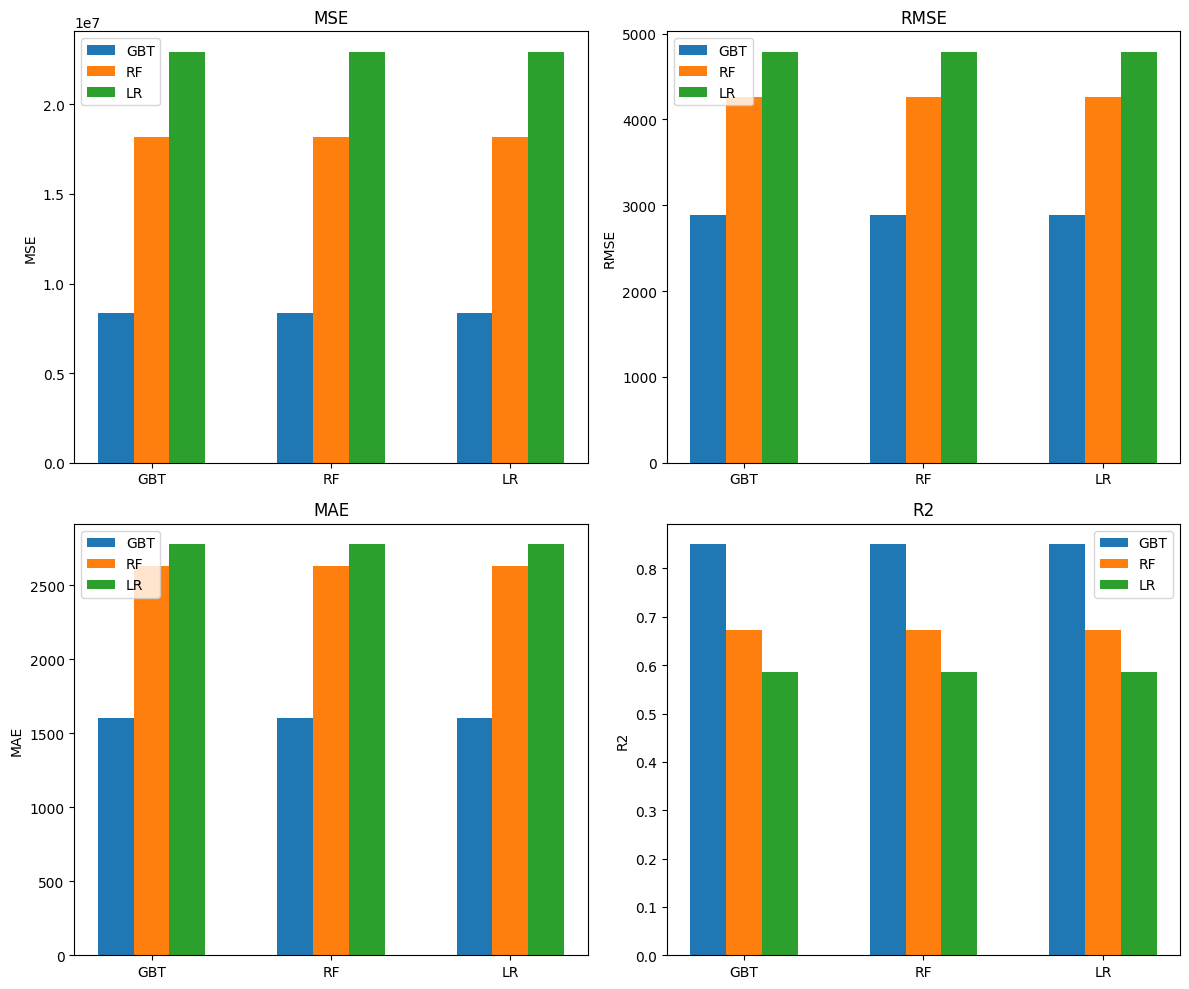

In [47]:
import numpy as np
x = np.arange(len(models)) 
width = 0.2  

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, metric in enumerate(metrics_names):
    ax = axes[i // 2, i % 2]
    ax.bar(x - width, data[metric][0], width, label='GBT')
    ax.bar(x, data[metric][1], width, label='RF')
    ax.bar(x + width, data[metric][2], width, label='LR')

    ax.set_title(f'{metric}')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylabel(metric)
    ax.legend()

plt.tight_layout()
plt.show()

In [66]:
spark.stop()